# MIDAA 101 (on 10X multiome)


As our first tutorial we will use the CD34+ positive 10X ATAC + GEX multiome dataset from [Setty et al.](https://www.nature.com/articles/s41587-019-0068-4). The dataset 

In [20]:
import sys
sys.path.append("/home/salvatore.milite/work/python_packages/daario/src/")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
# you need some extra packages to run the tutorial you can find the list on tutorial_requirements.txt

import midaa as maa

import torch
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# I like snapatac but you can you use whatever you want for preprocessing atac
import snapatac2 as snap
import muon as mu
import mudata
from muon import atac as ac
from pyjaspar import jaspardb
import pychromvar as pc

# sorry I'm kinda in love with ggplot 
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, xlim, theme_classic, theme, ggtitle, ggsave


In [68]:
%matplotlib inline
import matplotlib

matplotlib.rcParams['figure.figsize'] = [4.5, 4.5]
matplotlib.rcParams['figure.dpi'] = 90

The data can be obtained from the server of the original authors:

In [16]:
# !mkdir data/
# !wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_rna.h5ad -O data/cd34_multiome_rna_processed.h5ad # RNA data
# !wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_atac.h5ad -O data/cd34_multiome_atac.h5ad # ATAC data

In [22]:
ad_atac = sc.read('./data/cd34_multiome_atac.h5ad')
ad_rna = sc.read('./data/cd34_multiome_rna_processed.h5ad')

In [69]:
sc.pl.umap(ad_rna, color="celltype")

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [70]:
sc.pl.umap(ad_atac, color="celltype")

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


We will first run a bit of very fast and rough pre-processing on the atac dataset

In [27]:
# We will make the dataset a little bit more manageble by 
# using a subset of highly variable peaks 
ad_atac_hv = ad_atac
snap.pp.select_features(ad_atac, n_features=10000)

# We do the same for RNA, but you can fit the model on the 
# whole dataset, this is mainly for a matter of efficiency
ad_rna_hv = ad_rna[:,ad_rna.var["highly_variable"]].copy()

ad_atac_hv = ad_atac[:,ad_atac.var["selected"]].copy()
ad_atac_hv.raw = ad_atac_hv

2024-04-12 15:31:13 - INFO - Selected 10000 features.


In [33]:
# Scale and normalize so we cna use a Gaussian likelihood
sc.pp.scale(ad_rna_hv)
sc.pp.normalize_total(ad_atac_hv)
sc.pp.log1p(ad_atac_hv)
sc.pp.scale(ad_atac_hv)

We need a minimum of 3 inputs types to run MIDAA: the actual data matrices, an optional normalization factor and a likelihood type. We have a simple parser function for AnnData objects but it is always better to understand how to do it explicitly:

In [34]:
input_data = [ad_rna_hv.X, ad_atac_hv.X]
normalization = [np.ones(ad_rna_hv.X.shape[0]), np.ones(ad_atac_hv.X.shape[0])] # If you have a normalization factor for each cell, you can provide it here, we used scaled data so no need for that
input_distribution = ["G", "G"] # G for Gaussian, P for Poisson, NB for Negative Binomial, B for Bernoulli, Beta for Beta distribution and C for Categorical

# As a quick note, as you see MIDAA is developed for multi-modal data, 
# so even if you use it for a single modality the inputs are always lists.

We will now run a for loop to test different models (depending on what is you final goal you might even fix the number of archetypes to be in the range 5-10 as this could probably be enough, or maybe if you already know how many extreme groups you have): 

In [36]:
# A way to increase the network size fast
MULT = 4
models = {}

# This takes around 15 minutes on a NVIDIA V100 32GB
for i in range(2,12):
    models[i] = maa.fit_MIDAA(
        input_data,
        normalization,
        input_distribution,
        hidden_dims_dec_common = [64 * MULT, 128 * MULT], # Hidden dimensions of the common decoder
        hidden_dims_dec_last = [256 * MULT], # Hidden dimensions of the modality specific decoder
        hidden_dims_enc_ind = [128 * MULT], # Hidden dimensions of the modality specific encoder
        hidden_dims_enc_common = [64 * MULT], # Hidden dimensions of the common encoder
        hidden_dims_enc_pre_Z = [32 * MULT], # Hidden dimensions of the matrix specific encoder
        lr = 0.0001, # Learning rate
        gamma_lr = 0.1, # Learning rate decay factor
        steps = 1000, 
        narchetypes = i,
        batch_size = 9000,
        torch_seed = 3
    )

ELBO: 411358432.00000  : 100%|██████████| 1000/1000 [01:56<00:00,  8.62it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(
ELBO: 411006688.00000  : 100%|██████████| 1000/1000 [01:55<00:00,  8.62it/s]


We see how 5 is a potential candidate for a representative group of archetypes, then we have another drop of the loss at 10 which can also be used for a more refined analysis. We will go for 5 in this tutorial, but remember to explore more solutions.

2024-04-12 16:42:17 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-12 16:42:17 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


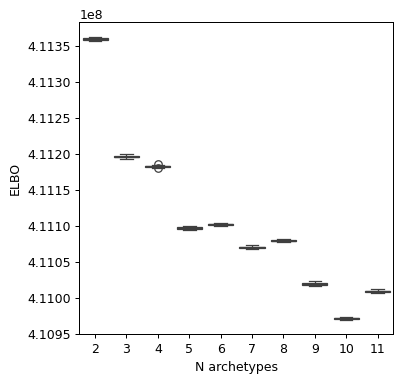

In [71]:
maa.plot_ELBO_across_runs(models, 950) # warm-up 950 epochs

Let's first save the model as the computation is quite expensive!

In [ ]:
best_model = res[5]

torch.save(best_model["deepAA_obj"].state_dict(), "best_model_aa_state_dict.pth")
torch.save(best_model["inferred_quantities"], "best_model_aa_inferred_quantities.pth")

# We can also save the ELBO values for this run
torch.save({k:v["ELBO"] for k,v in models.items()}, "ELBO_dict.pth")


In [ ]:
# To reload the model in the future you initialize it with the same parameters 

 best_model = maa.fit_MIDAA(
        input_data,
        normalization,
        input_distribution,
        hidden_dims_dec_common = [64 * MULT, 128 * MULT], # Hidden dimensions of the common decoder
        hidden_dims_dec_last = [256 * MULT], # Hidden dimensions of the modality specific decoder
        hidden_dims_enc_ind = [128 * MULT], # Hidden dimensions of the modality specific encoder
        hidden_dims_enc_common = [64 * MULT], # Hidden dimensions of the common encoder
        hidden_dims_enc_pre_Z = [32 * MULT], # Hidden dimensions of the matrix specific encoder
        lr = 0.0001, # Learning rate
        gamma_lr = 0.1, # Learning rate decay factor
        steps = 1, 
        narchetypes = 5,
        batch_size = 9000,
        torch_seed = 3
)
 # and then run
 maa.load_model_from_state_dict(best_model,input_data, "best_model_aa_state_dict.pth") # you need the initialized model, the same input and the state dict file

After this digression we can go on with our analysis and try to visualize the archetypes results. We can see how archetype follow mostly the erythroid lineage, with archetype 2,3 and 5 being related to Dendritic, stem and monocyte lines. Archetype 4 is still mostly in the transitioning stem cell portion of the dataset.

In [52]:
# Utility functions to add archetypes weights to the anndata object

ad_rna, arc_names = maa.add_to_obs_adata(best_model, ad_rna)
ad_atac, arc_names = maa.add_to_obs_adata(best_model, ad_atac)

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


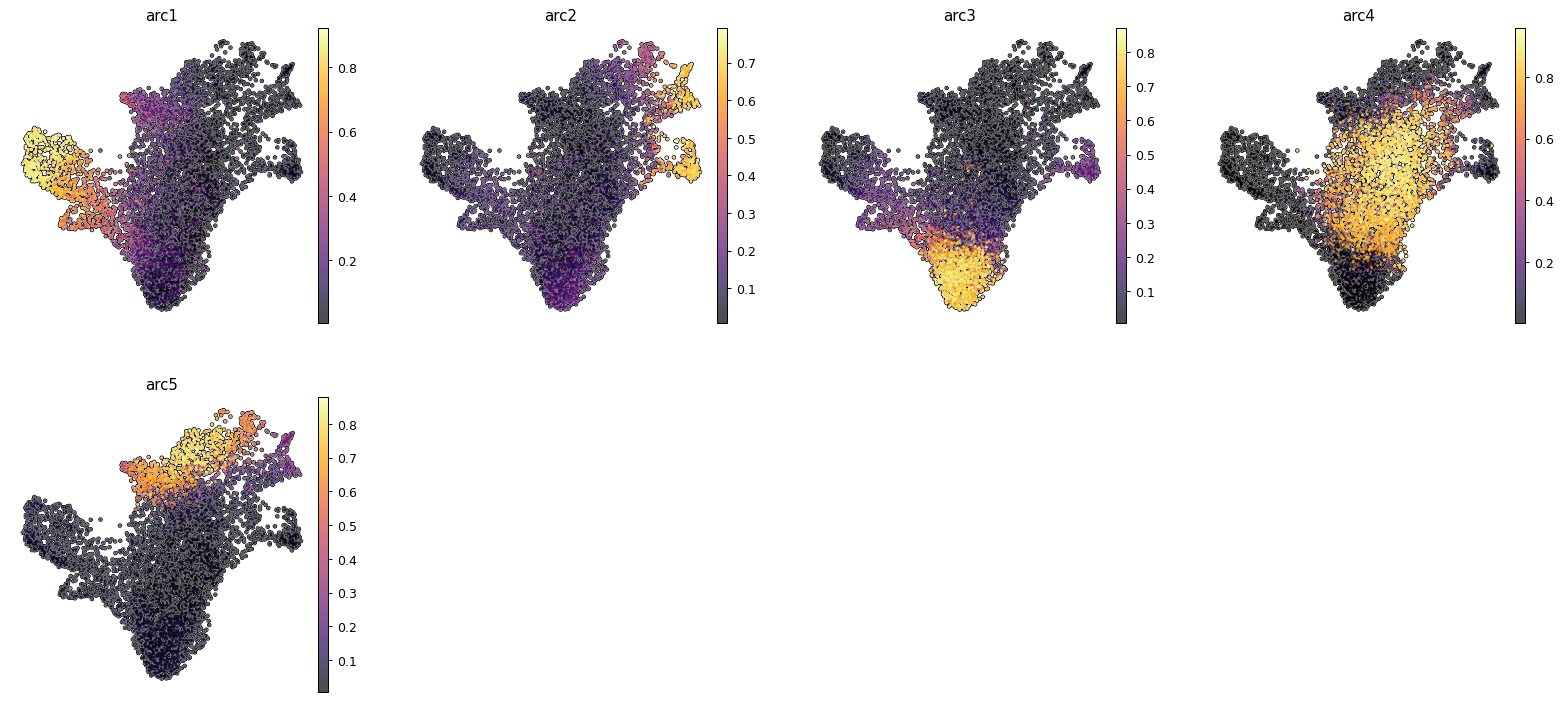

In [72]:
sc.pl.umap(ad_rna, color=arc_names, cmap = "inferno", frameon = False, add_outline=True)

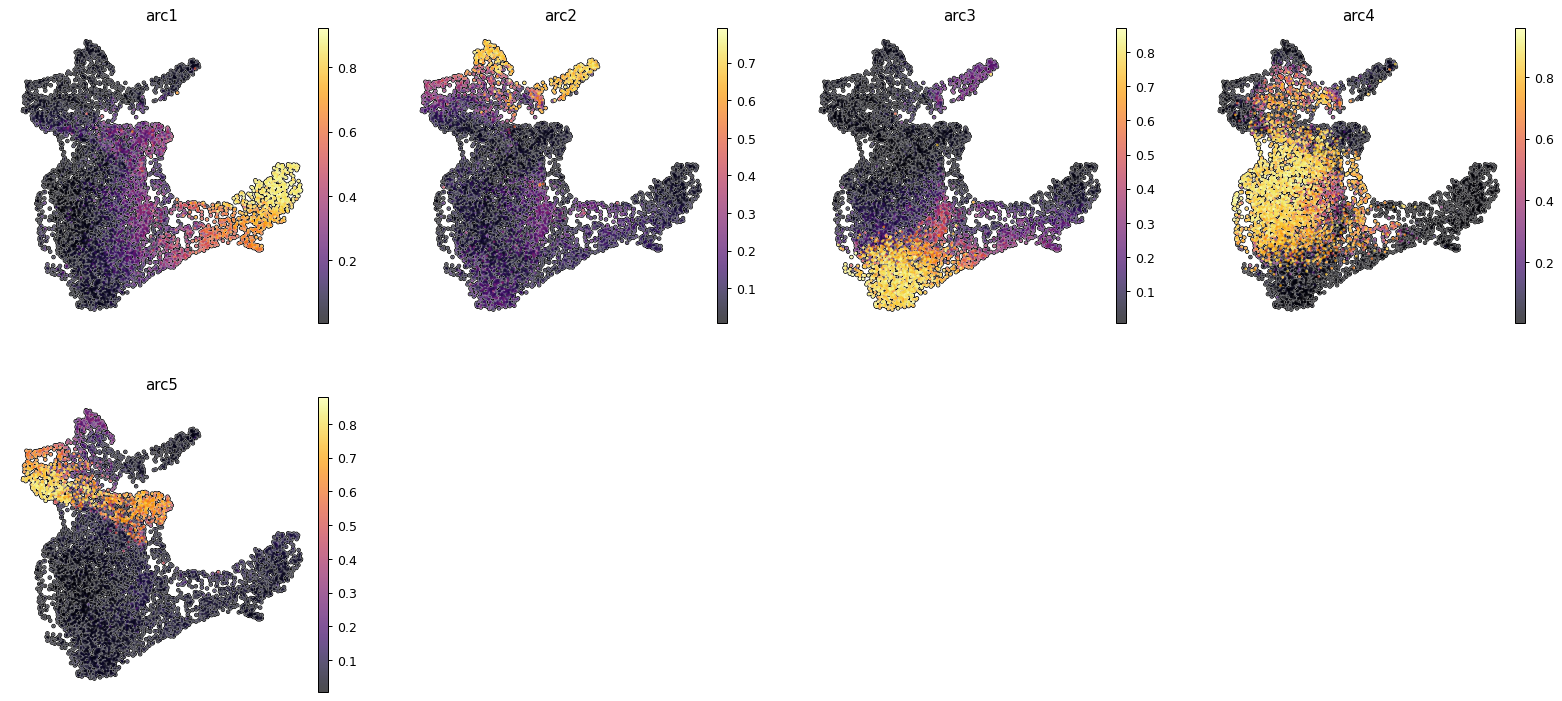

In [73]:
sc.pl.umap(ad_atac, color=arc_names, cmap = "inferno", frameon = False, add_outline=True)

Another way of visualizing MIDAA is to plot a 2d projection of the latent space on a polytope (this visualization is quite reflective of the latent space even though it  gets a bit hard to understand if you have a lot of archetypes)

(<Figure size 405x405 with 1 Axes>, <PolarAxes: >)

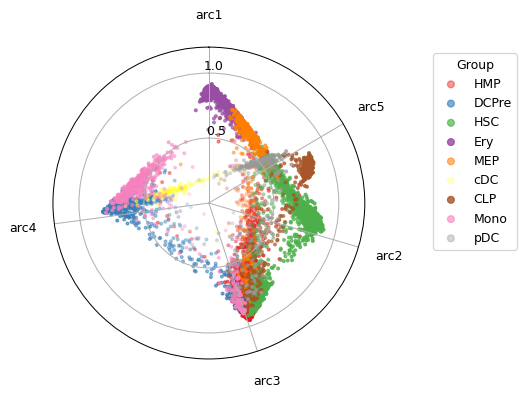

In [74]:
maa.plot_archetypes_simplex(best_model,  s =  5, color_by=ad_rna.obs["celltype"], cmap = "Set1")

Then we can exploit the chromatin to look at some transcription factors involved in the differentiation and look at how they correlate with the archetypes. To do so we will first compute TF deviations using pychromVAR

In [77]:
mdata = mudata.MuData({"rna": ad_rna, "atac": ad_atac})


In [31]:
# For more information you can look at the pychromVAR documentation (https://pychromvar.readthedocs.io/en/latest/)

pc.get_genome("hg38", output_dir="./")
pc.add_peak_seq(mdata, genome_file="./hg38.fa", delimiter=":|-")
pc.add_gc_bias(mdata)
pc.get_bg_peaks(mdata)

# get motifs
jdb_obj = jaspardb(release='JASPAR2020')
motifs = jdb_obj.fetch_motifs(
    collection = 'CORE',
    tax_group = ['vertebrates'])

pc.match_motif(mdata, motifs=motifs)

dev = pc.compute_deviations(mdata)

dev.write_h5ad("data/chromvar_deviations.h5ad")

ELBO: 9907476.00000  : 100%|██████████| 250/250 [00:13<00:00, 18.85it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(
ELBO: 9881814.00000  : 100%|██████████| 250/250 [00:13<00:00, 19.07it/s]


In [78]:
dev = sc.read_h5ad("data/chromvar_deviations.h5ad")

In [79]:
# We are again moving stuff around for plotting 
mdata.mod['chromvar'] = dev
mdata.mod['chromvar'].raw = dev
mdata["chromvar"].obsm["X_umap"] = mdata["rna"].obsm["X_umap"]

mdata.obsm["rna_umap"] = mdata["rna"].obsm["X_umap"]
mdata.obsm["atac_umap"] = mdata["atac"].obsm["X_umap"]


We will pick as example GATA1 and TCF3 which are important in respectively erythroid and dendritic differentiation. We can also see how their expression is quite low.

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


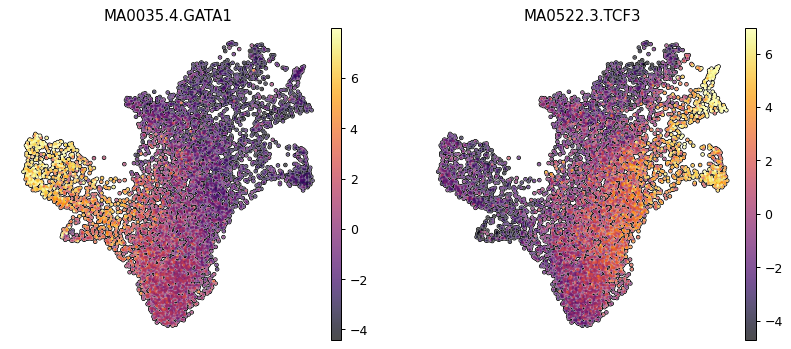

In [80]:
sc.pl.umap(mdata["chromvar"], color=['MA0035.4.GATA1', "MA0522.3.TCF3"], cmap = "inferno", frameon = False, add_outline=True, vmin='p1', vmax='p99')


In [81]:
sc.pl.umap(mdata["rna"], color=['GATA1', "TCF3"], cmap = "inferno", frameon = False, add_outline=True, vmin='p1', vmax='p99')


We now want to correlate the TF score to the archetypes weight, so we take archetypes 1 and 2 as we saw they were recapitulating erythroid and dendritic lineages.

In [82]:
df_plot_1 = pd.DataFrame({
 "TCF3" : np.array(mdata["chromvar"][:,"MA0522.3.TCF3"].X).flatten(),
 "modality" : "atac",
 "archetype2" : mdata["rna"].obs["arc2"]
}, index = mdata["rna"].obs.index)


df_plot_2 = pd.DataFrame({
 "GATA1" : np.array(mdata["chromvar"][:,"MA0035.4.GATA1"].X).flatten(),
 "modality" : "atac",
 "archetype1" : mdata["rna"].obs["arc1"]
}, index = mdata["rna"].obs.index)

And indeed we have a pretty satisfying correlation, which hints at the fact that maybe we did not waste the last hour but we are actually extracting some biology here.

In [84]:

(
    ggplot(df_plot_2, aes("archetype1", "GATA1", alpha="archetype1"))
    + geom_point(color = "lightblue")
    + stat_smooth(color = "darkblue") +
    xlim([0.1,0.77]) + theme_classic() + theme(legend_position = "none") +
    ggtitle("GATA1 accesibility") 
)

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4449 rows containing missing values.


<Figure Size: (640 x 480)>

In [85]:
(
    ggplot(df_plot_1, aes("archetype2", "TCF3", alpha="archetype2"))
    + geom_point(color = "lightblue")
    + stat_smooth(color = "darkblue") +
    xlim([0.1,0.75]) + theme_classic() + theme(legend_position = "none") +
    ggtitle("TCF3 accesibility")
)

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4473 rows containing missing values.


<Figure Size: (640 x 480)>


Once you have the archetypes you can do a lot of stuff with them, by using them as if they were proper sample :
* You can GSEA on their expression profile
* You can look at how they evolve over space
* You can compute enrichment of features across one archetype weights
* You can use archetype weights as covariates in a survival model

Imagination is you only limit!

### Generating new data

But want I would like to show in this last part of the tutorial which is less straightforward to use is how we can use our model in a generative fashion to simulate synthetic data. The idea is that we specify some coordinates in the simplex and then we sample from teh corresponding Dirichlet distribution. For instance in this example here we will sample a dataste mostly composed by 2 archetypes

In [97]:
AA_distribution = torch.tensor([1e-16,1e-16, 2,0.1, 2]).cpu()

# We have a custom function for this, just give the concentration of a Dirichlet distribution or a full A matrix
synthetic_matrices, _ = maa.generate_synthetic_data(best_model, AA_distribution, seed = 6, to_cpu = True)

We then treat it as a normal single cell experiment and try to look at some markers in ATAC and RNA space

In [98]:
import anndata as ad


cell_names = ["Cell_" + str(i) for i in range(synthetic_matrices[0].shape[0])]

ad_synt_rna = ad.AnnData(synthetic_matrices[0].detach().numpy()) 
ad_synt_rna.obs_names = cell_names
ad_synt_rna.var_names = ad_rna_hv.var_names

sc.pp.scale(ad_synt_rna)

sc.tl.pca(ad_synt_rna)

In [99]:
sc.pp.neighbors(ad_synt_rna, )
sc.tl.umap(ad_synt_rna )

# MPO is a stem marker and MEIS1 a dendritic one
sc.pl.umap(ad_synt_rna, color=[ "MPO", "MEIS1"],  save = "umap_rna_markers_synthetic.pdf", cmap = "inferno", frameon = False, add_outline=True,  vmax = "p95")


/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


In [100]:
import anndata as ad


ad_synt_atac = ad.AnnData(synthetic_matrices[1].detach().numpy())
ad_synt_atac.obs_names = cell_names
ad_synt_atac.var_names = ad_atac_hv.var_names
ad_synt_atac.var = ad_atac_hv.var

sc.pp.scale(ad_synt_atac)

In [101]:
# We look at the gene promoters 
ad_atac_hv.var[ad_atac_hv.var["nearestGene"] == "MPO"]

seqnames     start       end  width strand      score  \
chr17:58281664-58282164    chr17  58281664  58282164    501      *  218.00801   

                         replicateScoreQuantile  groupScoreQuantile  \
chr17:58281664-58282164                   0.988               0.979   

                         Reproducibility            GroupReplicate  ...  \
chr17:58281664-58282164                2  C13._.cd34_multiome_rep1  ...   

                        distToGeneStart  peakType distToTSS  nearestTSS  \
chr17:58281664-58282164           12058  Promoter       978  uc061tab.1   

                             GC   idx   count  selected      mean       std  
chr17:58281664-58282164  0.5329  8061  1988.0      True -0.009705  0.389574  

[1 rows x 21 columns]

In [102]:
ad_atac_hv.var[ad_atac_hv.var["nearestGene"] == "MEIS1"]

seqnames     start       end  width strand      score  \
chr2:66433317-66433817     chr2  66433317  66433817    501      *   31.32676   
chr2:66434847-66435347     chr2  66434847  66435347    501      *  205.71082   
chr2:66481155-66481655     chr2  66481155  66481655    501      *  203.22998   

                        replicateScoreQuantile  groupScoreQuantile  \
chr2:66433317-66433817                   0.992               0.968   
chr2:66434847-66435347                   0.989               0.979   
chr2:66481155-66481655                   0.988               0.978   

                        Reproducibility            GroupReplicate  ...  \
chr2:66433317-66433817                2  C12._.cd34_multiome_rep1  ...   
chr2:66434847-66435347                2   C6._.cd34_multiome_rep1  ...   
chr2:66481155-66481655                2   C6._.cd34_multiome_rep1  ...   

                       distToGeneStart  peakType distToTSS  nearestTSS  \
chr2:66433317-66433817             115  Promoter        96  uc057hgx.1   
chr2:66434847-66435347            1645  Promoter        35  uc057hgx.1   
chr2:66481155-66481655           47953  Intronic     14620  uc057hgx.1   

                            GC   idx   count  selected      mean       std  
chr2:66433317-66433817  0.5868  6123  1997.0      True -0.027297  0.135696  
chr2:66434847-66435347  0.5449  6125  2707.0      True -0.015174  0.114867  
chr2:66481155-66481655  0.4671  6142  2630.0      True -0.018967  0.189116  

[3 rows x 21 columns]

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


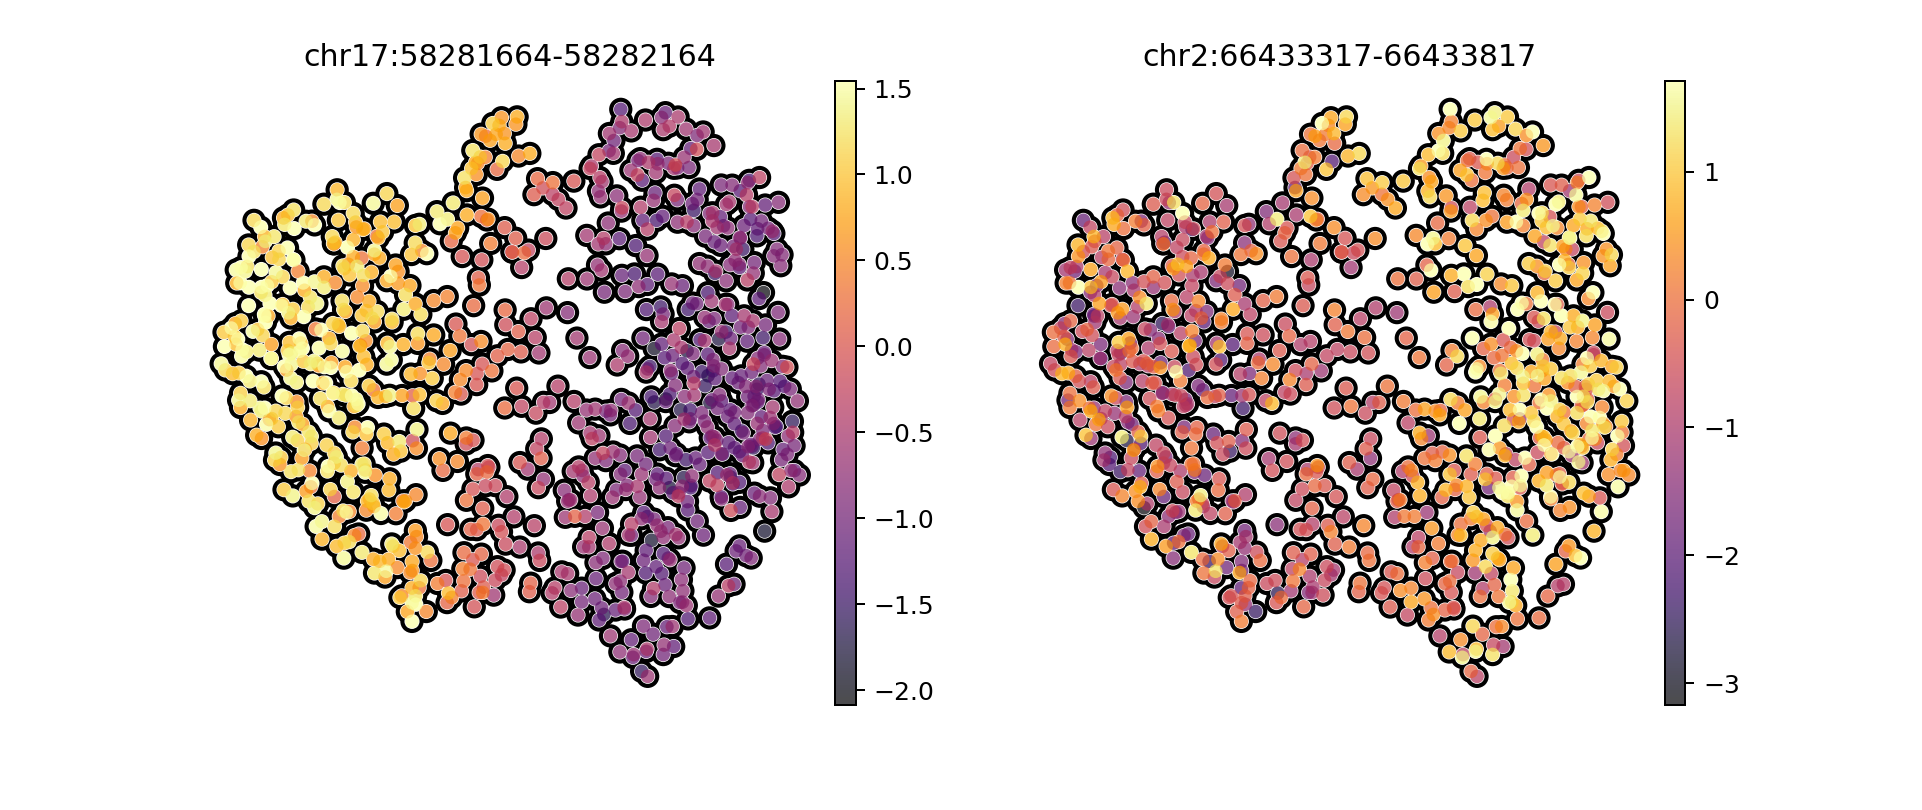

In [106]:
ad_synt_atac.obsm["X_umap"] = ad_synt_rna.obsm["X_umap"]
sc.pl.umap(ad_synt_atac, color = [ "chr17:58281664-58282164", "chr2:66433317-66433817"],  save = "umap_atac_markers_synthetic.pdf", cmap = "inferno", frameon = False, add_outline=True,  vmax = "p95")
